In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os, pickle
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.ndimage import gaussian_filter
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

from src.model import intensity
from src.theory import rate_fn, rate_fn_neg
from src.sim import sim_lif_perturbation, sim_lif_receptor_perturbation, sim_lif_perturbation_x, sim_lif_pop, create_spike_train, sim_determ_lif_recep_perturb
from src.phase_plane import dv, phase_plane_plot

In [3]:
from scripts import plot_fluctuations

from scripts.plot_exc_inh import *
from scripts.plot_uncoupled import *

## *Dynamics of Stochastic Integrate-and-Fire Networks*

In [7]:
J = 6
g = 0.3
E = 0.5

Ne = 200
Ni = 50
N = Ne + Ni
pE = 0.2
pI = 0.8

Jmat = np.zeros((N, N))
Jmat[:, :Ne] = np.random.binomial(n=1, p=pE, size=(N,Ne)) * J / pE / Ne
Jmat[:, Ne:] = np.random.binomial(n=1, p=pI, size=(N,Ni)) * (-g * J) / pI / Ni

tstop = 20
dt = .01
tplot = np.arange(0, tstop, dt)
perturb_amp = 2
perturb_len = 2

v, spktimes = sim_lif_perturbation(J=Jmat, E=E, tstop=tstop, dt=dt, perturb_len=perturb_len, perturb_amp=perturb_amp)

print(f"Resting Voltage:       {E}")
print(f"dt:                    {dt}")
print(f"Perturbation Length:   {perturb_len}")
print(f"Perturbation Amperage: {perturb_amp}")

(250,)
Resting Voltage:       0.5
dt:                    0.01
Perturbation Length:   2
Perturbation Amperage: 2


(0.0, 20.0)

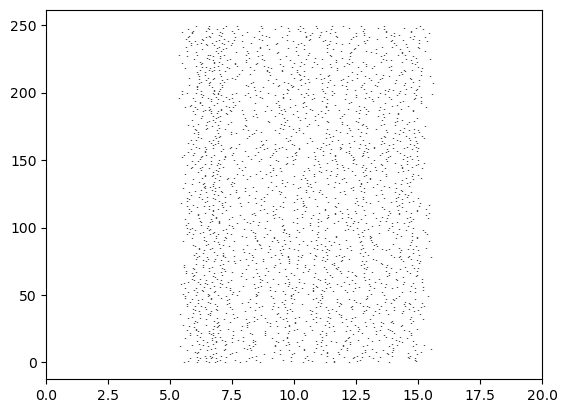

In [8]:
plt.plot(spktimes[:,0], spktimes[:,1], 'k|', markersize=0.5)
plt.xlim((0,tstop))

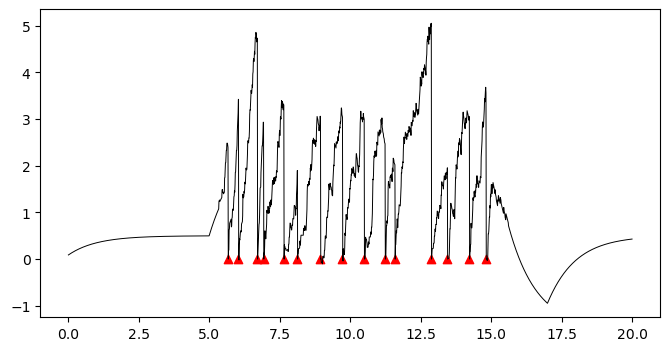

In [9]:
unit_0_spktimes = spktimes[spktimes[:,1] == 200.,0]
unit_0_spktimes

plt.figure(figsize=(8,4))
plt.plot(tplot, v[:,200], color='black', linewidth=0.7)
plt.scatter(unit_0_spktimes, np.repeat(0, len(unit_0_spktimes)), color='red', marker='^')

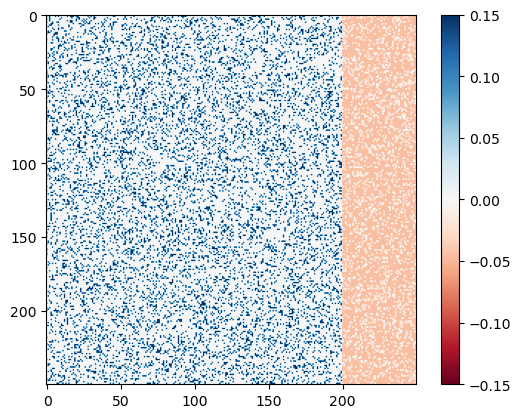

In [10]:
vmn, vmx = -np.max(np.abs(Jmat)), np.max(np.abs(Jmat))

plt.imshow(Jmat, vmin=vmn, vmax=vmx, cmap='RdBu')
plt.colorbar()

## Xiao-Jing Wang, *Probabilistic Decision-Making*

>The model combines a network architecture taken from Amit and Brunel (1997) and descriptions of synaptic currents from Wang (1999). The network is composed of $N$ neurons, with $N_E$ pyramidal cells (80%) and $N_I$ interneurons (20%) (Braitenberg and Schütz, 1991). It represents a local cortical circuit in the posterior parietal cortex. For the sake of clarity, I have used the simplest version of the model, with the assumption that the network encodes two stimulus directions (left or right). Each stimulus activates a distinct and small subpopulation of $fN_E$ excitatory cells ($f=0.15$). The remaining $(1-2f)N_E$ neurons do not respond to either of the stimuli. This is a simple realization of the common experimental protocol, where the physiological measurements aare done with the best and worst stimuli (preferred and null directions) of the recorded cell. Simulations reported in this paper were done with $N_E=1600$, $N_I=400$.

...

>Each neuron receives inputs from all other neurons, but with structured synaptic weights. The coupling strength between a pair of neurons is prescribed according to a "Hebbian" rule: the synapse is strong (weak) if in the past the two cells tended to be active in a correlated (anticorrelated) manner. Hence, inside a population, $w_j=w_+$, where $w_+ > 1$ is a dimensionless parameter that is equal to the relative strength of "potentiated" synapses with respect to the baseline. Unless specified otherwise, I used $w_+ = 1.7$. Between two different selective populations, and from the nonselective population to selective ones, $w_j=w_-$, where $w_- < 1$ measures the strength of synaptic "depression." Other connections have $w_j = 1$. It is assumed by synaptic modifications, because synaptic depression compensates the effect of potentiation at the network level. More specifically, by choosing $w_- = 1 - f(w_+ - 1)/(1-f)$, the overall recurrent excitatory synaptic drive in the spontaneous state remains constant as $w_+$ is varied (Amit and Brunel, 1997). Synaptic efficacies remain fixed through the simuation.

In [11]:
def create_sparse_connect_mat(J, g, Ne, Ni, pE, pI, f, wstrong, plot=False):
    N = Ne + Ni
    wweak = 1 - ((f*(wstrong - 1)) / (1 - f))
    fNe = int(f * Ne)

    Jmat = np.zeros((N, N))
    Jmat_exc = np.zeros((N, N))

    Jmat[:, :Ne] = np.random.binomial(n=1, p=pE, size=(N,Ne)) * J / pE / Ne
    Jmat[:, Ne:] = np.random.binomial(n=1, p=pI, size=(N,Ni)) * (-g * J) / pI / Ni

    # wj = 1
    Jmat_exc[:,:Ne] = 1 # from all excitatory to all else

    # wj = w+
    Jmat_exc[:fNe, :fNe] = wstrong # from selective A to selective A
    Jmat_exc[fNe:(2*fNe), fNe:(2*fNe)] = wstrong # from selective B to selective B

    # wj = w-
    Jmat_exc[fNe:(2*fNe), :fNe] = wweak # from selective A to selective B
    Jmat_exc[:fNe, fNe:(2*fNe)] = wweak # from selective B to selective A
    Jmat_exc[:(2*fNe),(2*fNe):Ne] = wweak # from nonselective to selective

    Jmat[:,:Ne] *= Jmat_exc[:,:Ne]

    Jmat_max = np.max(np.abs(Jmat))
    Jmat_emax = np.max(np.abs(Jmat_exc))

    if plot:
        fig, ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].imshow(Jmat, vmin=-Jmat_max, vmax=Jmat_max, cmap='RdBu')
        ax[1].imshow(Jmat_exc[:,:Ne], vmin=-Jmat_emax, vmax=Jmat_emax, cmap='RdBu')

    return Jmat

In [277]:
def create_connect_mat(Ne, Ni, f, wstrong, plot=False):
    N = Ne + Ni
    wweak = 1 - ((f*(wstrong - 1)) / (1 - f))
    fNe = int(f * Ne)

    Jmat = np.zeros((N, N))

    # wj = 1
    Jmat[:,:Ne] = 1 # from all excitatory to all else

    # wj = w+
    Jmat[:fNe, :fNe] = wstrong # from selective A to selective A
    Jmat[fNe:(2*fNe), fNe:(2*fNe)] = wstrong # from selective B to selective B

    # wj = w-
    Jmat[fNe:(2*fNe), :fNe] = wweak # from selective A to selective B
    Jmat[:fNe, fNe:(2*fNe)] = wweak # from selective B to selective A
    Jmat[:(2*fNe),(2*fNe):Ne] = wweak # from nonselective to selective

    Jmat[:,Ne:] = 1 # from inhibitory to all else

    Jmat_max = np.max(np.abs(Jmat))

    if plot:
        fig, ax = plt.subplots(figsize=(8,4))
        ax.imshow(Jmat, vmin=-Jmat_max, vmax=Jmat_max, cmap='RdBu')
        plt.show()

    return Jmat

XJW cortical network parameters:
- $V_{L}=-70 { mV}$
- $V_{th}=-50 { mV}$
- $V_{reset}=-55 { mV}$
- $C_{m}^{pyr}=0.5 { nF}$
- $C_{m}^{inh}=0.2 { nF}$
- $g_{L}^{pyr}=25{ nS}$
- $g_{L}^{inh}=20{ nS}$
- $\tau_{ref}^{pyr}=2{ mS}$
- $\tau_{ref}^{inh}=1{ mS}$
- $\tau_{m}^{pyr}=20{ mS}$ ($\tau_m=C_m / g_L$)
- $\tau_{m}^{inh}=10{ mS}$

LIF model:
$$
C_{m}\frac{dV(t)}{dt} = -g_{L}(V(t)-V_{L})-I_{syn}(t)
$$

$$
\frac{dV(t)}{dt}=-\frac{g_L}{C_m}(V(t)-V_L)-I_{syn}(t)
$$

$$
\frac{dV(t)}{dt}=-\frac{1}{\tau}(V(t)+V_L)-I_{syn}(t)
$$

Stochastic LIF model:
```
v[t] = v[t-1] + dt*(-v[t-1] + E) + J.dot(n)
```
$$
\frac{dV(t)}{dt}=-V(t)+E+\sum_{c}J_{c}n
$$

## Simulation

### Deterministic Case (original XJW)

In [466]:
def gen_sensory_stim(mu_0=20, dt=None, rho=None, coh=None, f=0.15, N=2000, sim_len=4, t_start=1, plot=False):
    """
    Generate stimulus rates across time for 2 seconds. Rates are resampled every 50 ms.
    """
    if len(np.shape(rho)) > 0:
        rho_A,rho_B = rho
    else:
        rho_A = mu_0 / 100
        rho_B = mu_0 / 100
    mu_A = mu_0 + rho_A*coh
    mu_B = mu_0 - rho_B*coh

    print(f"A mean rate: {mu_A}")
    print(f"B mean rate: {mu_B}")

    fNe = int(f * N * 0.8) # number of selective neurons

    Nt = int(sim_len / dt) # time points

    switch_idx = int(0.05 / dt) # every 50 ms
    num_switches = int((2 / dt) / switch_idx)

    stim_A_rate_list = np.random.normal(loc=mu_A, scale=4.0, size=num_switches)
    stim_B_rate_list = np.random.normal(loc=mu_B, scale=4.0, size=num_switches)
    
    stim_rates = np.zeros((Nt, N))
    stim_rates_A = np.zeros(Nt)
    stim_rates_B = np.zeros(Nt)

    stim_spikes = np.zeros((Nt, N))
    fNe2 = int(2*fNe)

    for i in range(num_switches):
        swi = int(i*switch_idx + (t_start / dt))
        
        stim_rates_A[swi:(swi+switch_idx)] = stim_A_rate_list[i]
        stim_rates_B[swi:(swi+switch_idx)] = stim_B_rate_list[i]

        stim_spikes[swi:(swi+switch_idx),:fNe] = (np.random.rand(switch_idx,fNe) < (stim_A_rate_list[i] * dt))*1
        stim_spikes[swi:(swi+switch_idx),fNe:fNe2] = (np.random.rand(switch_idx,fNe) < (stim_B_rate_list[i] * dt))*1

    #stim_rates = {'A': stim_rates_A, 'B': stim_rates_B}
    stim_rates[:,:fNe] = stim_rates_A[:,np.newaxis].repeat([fNe], axis=1)
    stim_rates[:,fNe:fNe2] = stim_rates_B[:,np.newaxis].repeat([fNe], axis=1)

    if plot:
        plt.plot(stim_rates_A, color='r', label='A')
        plt.plot(stim_rates_B, color='g', label='G')
        plt.show()

    return stim_rates, stim_spikes

In [234]:
from scipy.stats import norm

Resting Voltage:                   -0.7
Voltage Threshold:                 -0.5
Voltage Reset:                     -0.55
Time Step:                         0.0001


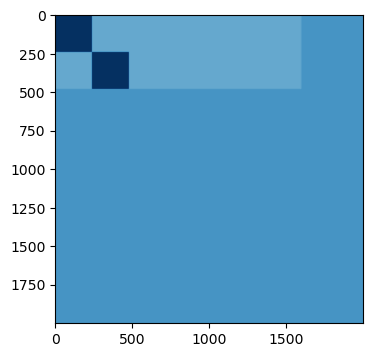

A mean rate: 21.28
B mean rate: 18.72


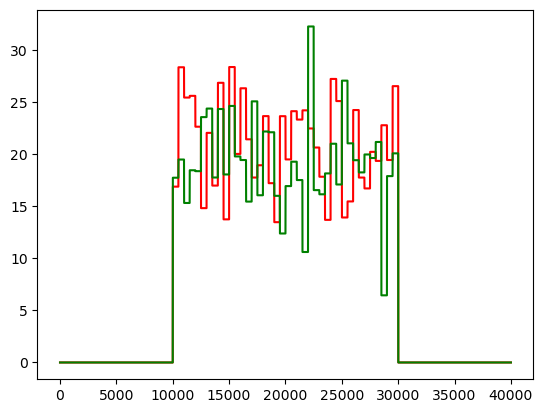

In [467]:
E = -0.7 # originally -70 mV
v_th = -0.5 # originally -50 mV
v_r = -0.55 # originally -55 mV

Ne = 1600
Ni = 400
N = Ne + Ni
pE = 0.2
pI = 0.8
f = 0.15
wstrong = 1.7

tstop = 4
dt = 0.0001
tplot = np.arange(0, tstop, dt)

g_l = {"e": 25, "i": 20} # excitatory and inhibitory leak conductance
c_m = {"e": 0.5, "i": 0.2} # excitatory and inhibitory membrane capacitance

tau_recep = {"ampa": 0.002, "nmda_rise": 0.002, "nmda_decay": 0.100, "gaba": 0.005}

g_ext = {"ampa_e": 2.1, "ampa_i": 1.62}

g_rec = {"ampa_e": 0.05, "nmda_e": 0.165, "gaba_e": 1.3,
         "ampa_i": 0.04, "nmda_i": 0.13, "gaba_i": 1.0}

Vc = {"e": 0, "i":-0.7}

EI_ratio = Ne,Ni

print(f"Resting Voltage:                   {E}")
print(f"Voltage Threshold:                 {v_th}")
print(f"Voltage Reset:                     {v_r}")
print(f"Time Step:                         {dt}")

Jmat = create_connect_mat(Ne, Ni, f, wstrong, plot=True)
stim_rates,stim_spikes = gen_sensory_stim(dt=dt, coh=6.4, plot=True)

#v, spktimes, syn_currents, gating_vars 

In [498]:
v, spktimes, spktrains, syn_currents, gating_vars = sim_determ_lif_recep_perturb(J=Jmat, E=E, g_l=g_l, c_m=c_m, g_ext=g_ext, g_rec=g_rec, tau_recep=tau_recep, Vc=Vc, EI_ratio=EI_ratio, In_sens=(dt*stim_rates), tstop=tstop, dt=dt, v_th=v_th, v_r=v_r) # (dt*stim_rates) in sensory input

(2000,)


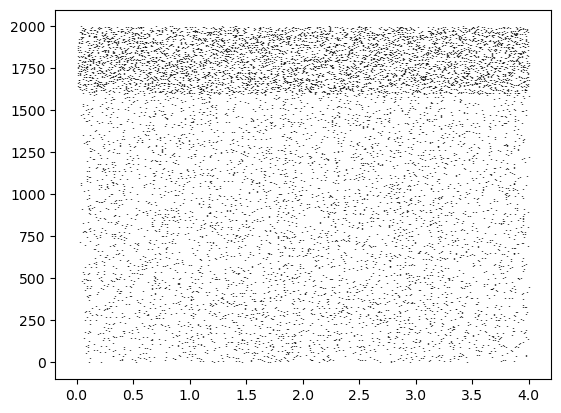

In [499]:
plt.plot(spktimes[:,0], spktimes[:,1], 'k|', markersize=0.5)
#plt.ylim((0,480))
plt.show()

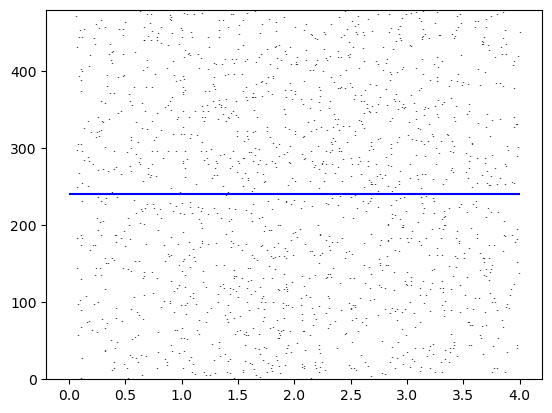

In [500]:
plt.plot(spktimes[:,0], spktimes[:,1], 'k|', markersize=0.5)
plt.hlines(240, xmin=0, xmax=max(tplot), color='blue')
plt.ylim((0,480))
plt.show()

In [504]:
a_spks = spktrains[:,:240]
b_spks = spktrains[:,240:480]

g = norm.pdf(np.arange(-0.1, 0.1, dt), 0, 0.05)
conv = lambda x: np.convolve(x, g, mode='same')
raster_smoothed_A = np.apply_along_axis(conv, axis=0, arr=a_spks)
raster_smoothed_B = np.apply_along_axis(conv, axis=0, arr=b_spks)

(0.0, 2.0)

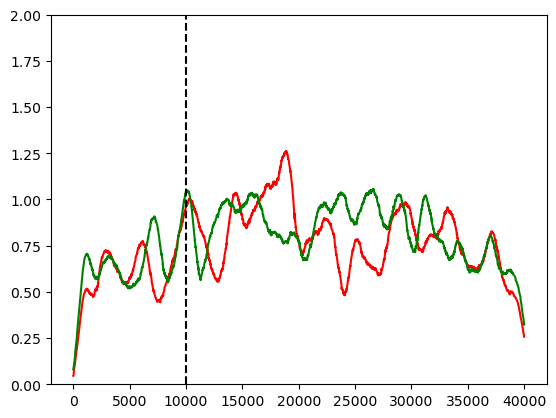

In [506]:
plt.plot(raster_smoothed_A.mean(axis=1), color='r')
plt.plot(raster_smoothed_B.mean(axis=1), color='g')

plt.vlines(10000, ymin=0, ymax=50, color='k', linestyle='--')
plt.ylim((0,2))

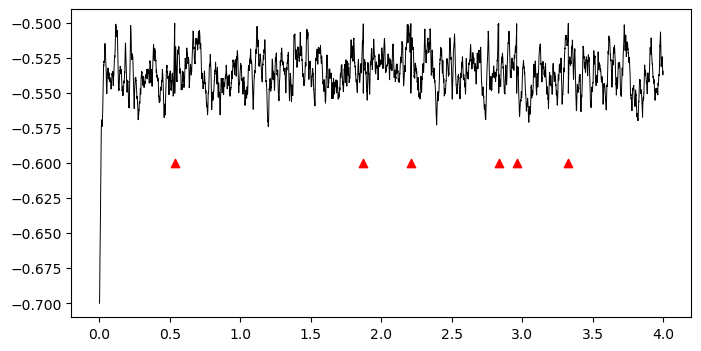

In [502]:
uu = 200
unit_spktimes = spktimes[spktimes[:,1] == uu,0]
unit_spktimes

plt.figure(figsize=(8,4))
plt.plot(tplot, v[:,uu], color='black', linewidth=0.7)
plt.scatter(unit_spktimes, np.repeat(-0.6, len(unit_spktimes)), color='red', marker='^')

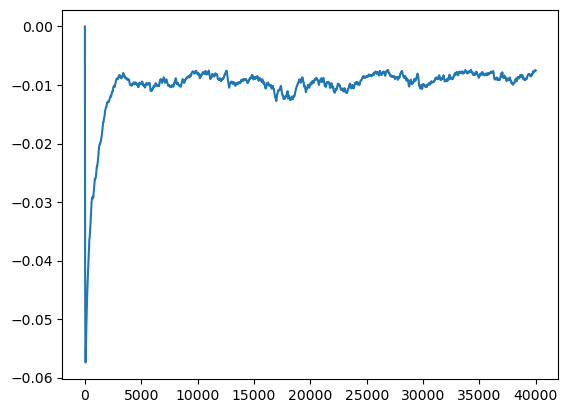

In [496]:
plt.plot(syn_currents['nmda'][:,200])
#plt.xlim((15000,20000))

In [403]:
Nt = int(tstop / dt)
s_nmda = np.zeros(Nt)
x = np.zeros(Nt)
s_ampa = np.zeros(Nt)
g_nmda = g_rec['nmda_e']
g_ampa = g_rec['ampa_e']
tau_nmda_rise = tau_recep['nmda_rise']
tau_nmda_decay = tau_recep['nmda_decay']
tau_ampa = tau_recep['ampa']

n = (np.random.rand(Nt) < (30*dt))*1

for t in range(1,Nt):
    s_ampa[t] = s_ampa[t-1] + dt*((-1/tau_ampa)*s_ampa[t-1]) + n[t]
    x[t] = x[t-1] + dt*((-1/tau_nmda_rise)*x[t-1]) + n[t]
    s_nmda[t] = s_nmda[t-1] + dt*((-1/tau_nmda_decay)*s_nmda[t-1] + 0.5*x[t]*(1-s_nmda[t-1]))